# Projet Datascientest | DST_DEC22 | Rapport de modélisation

**Participants** : Olga TOLSTOLUTSKA, Mohamed BACHKAT, Charly LAGRESLE \
**Mentor** : Manu PORTEL \
**Date du document** : 2023/02/20

## Contexte et objectif

Rakuten est un site de e-commerce, regroupant près de 1.3 milliards d'utilisateurs. Afin de faciliter la gestion des suggestions de leurs recherches ou des recommandations qui leurs seront proposées, il est important de classifier les produits. Du fait de la quantité de produits et de leurs catégories associées, ce classement ne peut ni être fait manuellement, ni être régi par des règles. Une approche plus flexible, efficace et reproductible est donc à mettre en place. 

L'objectif est de prédire le code de chaque produit, c'est-à-dire sa catégorie, sur la base d'une analyse de données textuelles et d'images.



## Prérequis

### Équilibrage : 

Nous avions la possibilité d'effectuer un rééquilibrage du dataset, via notamment des méthodes telles que l'*oversampling* ou l'*undersampling*. Ce choix n'a pas été fait, afin de conserver la pureté du dataset fourni.

Nous chercherons donc à étudier les métriques non faussées par le déséquilibrage du dataset fourni.

### Choix des métriques

Plusieurs possibilités sont ici aussi à notre disposition. Au sein des réseaux de neurones, le suivi de leurs performances est effectué sur la métrique *SparseCategoricalAccuracy*. Nous disposons également d'une métrique appelée *BalancedSparseCategoricalAccuracy*.

Pour classer les différents réseaux entre eux, nous avons choisi d'utiliser le *classification_report_imbalanced* qui prend en charge le déséquilibre des données avant de renvoyer ses métriques.

Pour rappel, 27 catégories sont à notre disposition. Cela signifie qu'un score de plus de 3.7% est d'ores et déjà supérieur à un modèle purement aléatoire.

Nous avons fait face à beaucoup d'*overfitting*. Pour tous les modèles, une CrossValidation à 3 échantillons a été effectuée en prévention.



## Modèles simples de Machine Learning

### Texte

Comme l'expliquait le rapport d'exploration, les données textuelles sont très hétérogènes :
* la longueur des textes est varie de 0 à plusieurs milliers de mots dans les colonnes *description* et *designation*
* la colonne *description* comprend de nombreuses valeurs manquantes

Nous choisissons donc de merger les colonnes *designation* et *description* pour ne se concentrer que sur cette nouvelle colonne *text*.

Sur celle-ci, un travail de nettoyage est effectué : suppression des mots d'arrêt, des caractères speciaux, mise en minuscule, stemmatisation.

Pour accélérer les algorithmes et en se basant sur notre analyse exploratoire,  les textes ont été rognés aux 500 premiers mots.


#### Modèles testés

Plusieurs modèles ont été mis en place. Les modèles sont ici utilisés dans leur configuration par défaut, c'est-à-dire sans hyperparamètres. Les scores mentionnés sont issus du rapport de classification déséquilibré. 

| Modèle                | Type     | Accuracy | Recall | F1-Score | Durée de l'entrainement |
|-----------------------|----------|-----------|--------|----------|-------------------------|
| DecisionTree         | Simple   | 0.60 | 0.63 | 0.61 | 47s |
| KNC                  | Simple   | 0.49 | 0.46 | 0.46 | 28s |
| RandomForest         | Ensemble | 0.69 | 0.69 | 0.69 | 94s |
| GradientBoosting     | Ensemble | 0.62 | 0.56 | 0.56 | 2497s |
| AdaBoost             | Ensemble | 0.31 | 0.32 | 0.27 | 148s |


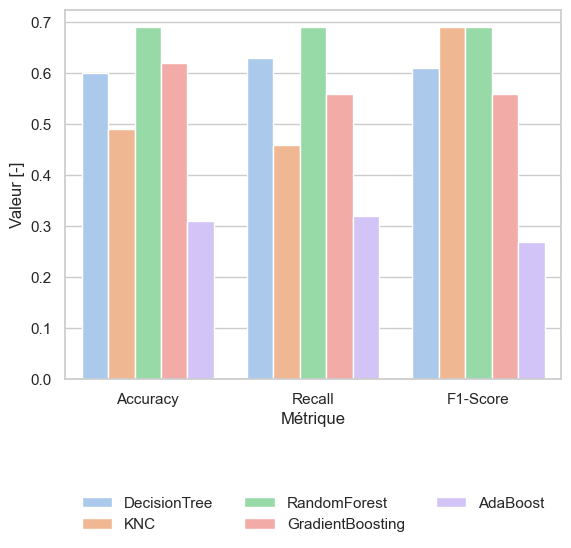

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

sns.set_theme(style="whitegrid", palette="pastel")

df = pd.DataFrame.from_dict(
    {"Modèle" : ["DecisionTree", "KNC", "RandomForest", "GradientBoosting", "AdaBoost"],
    "Accuracy" : [.60, .49, .69, .62, .31],
    "Recall" : [.63, .46, .69, .56, .32],
    "F1-Score" : [.61, .69, .69, .56, .27],
    #"Duration" : [257, 171, 0, 141, 94, 2497, 148],
    }
)
df_melted = df.melt(id_vars="Modèle", value_vars=["Accuracy", "Recall", "F1-Score"], value_name="Valeur [-]", var_name="Métrique")
sns.barplot(data=df_melted, x="Métrique", y="Valeur [-]", hue="Modèle");
plt.legend(loc='lower center', frameon=False, bbox_to_anchor=(0.5, -.45), ncol=len(df_melted.columns));

Les scores obtenus par les modèles de *machine learning* sont au-delà d'un modèle purement aléatoire. L'utilisation de métriques propres à gérer des jeux de données déséquilibrés nous permet d'obtenir des scores de *precision* et de *recall* proches.

Le modèle *RandomForest* est le plus performant dans sa configuration d'origine avec un score de 69%.


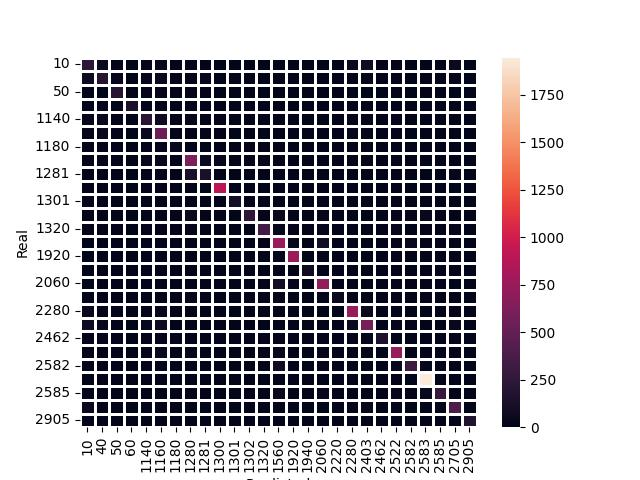

In [7]:
Image("images/crosstab-rf.jpg")

NOTE : si le temps nous le permet, une étude GridSearchCV sera effectuée affin de déterminer les hyperparamètres les plus performants de chaque modèle.


### Image

#### Mise en place des données

Les images sont importées via un ImageDataGenerator afin de :
* ne pas les charger directement en mémoire
* appliquer un redimensionnement 
* appliquer des transformations aléatoires

#### Modelisation Machine Learning

Prétraitement de données : 
Les images ont été réduites à 224x224 pixels dans l'échelle de gris, soit 50 176 variables par image en niveau de gris. Ce nombre est multiplié par 3 si les 3 canaux RGB sont utilisés (en *Deep learning*).


##### Réduction de dimensions 

Avant effectuer le traitement des images il est intéressant d'appliquer une approche de réduction de dimensions dans le but d'éliminer les blocs non pertinents des images et d'identifier le masque qu'on peut potentiellement appliquer lors de pré-traitement des images.  

L'algorithme de réduction de dimension *PCA* avec 90% de la variance a retenu 800 variables. 
Le tableau ci-dessus compare les scores de modèles entraînés avec les variables réduites et complètes. 

|Modèle	  |Score pca         |Score |
|---------|------------------|------|
|LogReg   |    0.165         |0.165 |
|SVM      |    0.135         |0.135 |
|RFC      |    0.115         |0.230 |

Pour comparer l'image en entrée et le masque obtenu, nous avons affiché un exemple d'image. 

<img src="images/ML-exemple-d-image.png" />
<!-- ![Affichage d'un image de taille 224x224 en gris](images/ML-exemple-d-image.png) -->

Figure : Affichage d'un image de taille 224x224 en gris 
<img src="images/ML-exemple-d-image-avec-le-masque.png" />
<!-- ![Masque appliqué à l'image](images/ML-exemple-d-image-avec-le-masque.png) -->




Bien que nous avons réussi à identifier le masque et les blocs d'image potentiellement non pertinents, nous pouvons constater que visuellement le masque se met au milieu d'image et ne donne pas une suite logique. 


#### Modèles testés

##### Modèles Machine Learning appliqués
    
Sur la base de 50 176  variables, nous avons entraîné et testé différents modèles de *Machine Learning* en utilisant  la validation *StratifiedKFold* avec 5 *folds*. 

Le tableau ci-dessus contient la comparaison de modèles. 


| Classifier | Configuration | Le temps | Accuracy | Precision weighted | Recall weighted | F1 weighted |
|------------|---------------|----------|----------|--------------------|-----------------|-------------|
| LogReg     | max_iter=10000, tol=0.1            | 2        | 0.18     | 0.16               | 0.18            | 0.16        |
| RF         |              | 2        | 0.12     | 0.04               | 0.12            | 0.04        |
| KNN        |              | 2        | 0.18     | 0.16               | 0.18            | 0.16        |
| SVM        | C=1, kernel='linear'             | 2        | 0.18     | 0.17               | 0.18            | 0.17        |
| GradBoost  |              | 2        | 0.09     | 0.08               | 0.09            | 0.06        |


Figure : Tableau de comparaison de classifiers 

 
Le tableau suivant contient F1 score de modèles testés pour chaque classe de catégorie de produit. 

|Modèle|LogReg   |RF    |KNN     |SVM    |GradBoost|
|------|---------|------|--------|-------|---------|
|10    |0.00     |0.00  |0.13    | 0.00  |0.11     |
|40    |0.00     |0.00  |0.00    | 0.00  |0.00     |
|50    |0.00     |0.00  |0.00    | 0.00  |0.00     |
|60    |0.00     |0.00  |0.00    | 0.00  |0.00     |
|1140  |0.00     |0.00  |0.14    | 0.12  |0.00     |
|1160  |0.14     |0.00  |0.24    | 0.11  |0.00     |
|1180  |0.00     |0.00  |0.00    | 0.00  |0.00     |
|1280  |0.15     |0.00  |0.09    | 0.16  |0.00     |
|1281  |0.00     |0.00  |0.00    | 0.00  |0.00     |
|1300  |0.00     |0.00  |0.12    | 0.00  |0.00     |
|1301  |0.00     |0.00  |0.00    | 0.00  |0.17     |
|1302  |0.36     |0.00  |0.00    | 0.20  |0.00     |
|1320  |0.00     |0.00  |0.00    | 0.13  |0.12     |
|1560  |0.07     |0.00  |0.10    | 0.07  |0.00     |
|1920  |0.42     |0.00  |0.50    | 0.33  |0.15     |
|1940  |0.00     |0.00  |0.00    | 0.00  |0.00     |
|2060  |0.13     |0.00  |0.00    | 0.08  |0.00     |
|2220  |0.00     |0.00  |0.00    | 0.00  |0.00     |
|2280  |0.38     |0.00  |0.30    | 0.34  |0.00     |
|2403  |0.11     |0.00  |0.26    | 0.11  |0.00     |
|2462  |0.00     |0.00  |0.00    | 0.00  |0.00     |
|2522  |0.18     |0.15  |0.29    | 0.28  |0.00     |
|2582  |0.00     |0.00  |0.00    | 0.00  |0.00     |
|2583  |0.25     |0.23  |0.21    | 0.09  |0.16     |
|2585  |0.00     |0.00  |0.00    | 0.00  |0.00     |
|2705  |0.31     |0.00  |0.29    | 0.18  |0.00     |
|2905  |0.00     |0.00  |0.00    | 0.00  |0.00     |

Figure : Tableau de comparaison de classifiers de F1 weighted par classe 


REMARQUE : Dans le cadre de test l'entraînement a été effectué que avec 1000 images. Les données seront à jour par la suite à la fin d'entrainement avec plus de données. 



##### Modèle SVM :

La première modélisation des images s'est opérée avec *SVM*  (avec une réduction de dimensions par *PCA*) car il est le modèle le plus efficace pour la reconnaissance de formes. Le score obtenu a été de 0.3. Ce score médiocre n'est pas suffisant et un modèle plus avancé a été proposé qui est l'arbre de décision boosté. Olga qui a notamment travaillé sur les modèles de classification de ML a elle aussi obtenu des résultats non satisfaisants. Elle a quant à elle réalisé une cross validation avec des grilles et elle a travaillé sur les métriques.  En fait les modèles de classification de Machine learning ne sont pas assez puissants pour notre problèmatique de classification d'images et il faut passer au deep learning. 

Le meilleur modèle est SVM avec son score 0.3. Sa performance reste faible. 
Il est possible que les modèles de Machine Learning ne prennent pas en compte la totalité de complexité des images fournies par dataset.
Du coup nous allons nous focaliser sur un des algorithmes plus performants Deep Learning qui permet d’identifier et extraire lui-même les features significatives et identifier de patterns complexes. 


## Modèles de *deep learning*

### Texte

L'extraction des données est faite sur la colonne *text* résultant de la fusion des deux colonnes descriptives du produit. 

* Modèles
    * Neural_Simple : modèle simple à couches denses se basant sur la sortie numérique de notre vectorisation TFIDF
    * Neural_Embedder : modèle similaire à *Neural_Simple* mais où la première couche est une couche d'*embedding*. 
    
Le modèle *Neural_Embedder*, a la particularité de présenter une couche d'embedding qui nous permet de fournir directement un ensemble de mots à ce réseau de neurones. La vectorisation pour ce réseau gère 50 000 mots et seuls les 500 plus fréquents sont conservés. 


**Organisation des couches du réseau de neurones Neural_Embedder**

| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|text_input (Embedding) |     (None, 500, 32)  |         1600000  | 
|text_conv_1 (Conv1D) |       (None, 494, 32)  |         7200 |     
|text_max_1 (MaxPooling1D) |  (None, 98, 32)  |          0    |     
|text_conv_2 (Conv1D) |       (None, 92, 32)   |         7200  |    
|text_glob_1 (GlobalMaxPooling1D) | (None, 32)  |      0    |   
|text_drop_2 (Dropout) |      (None, 32)        |        0    |     
|text_output (Dense)   |      (None, 27)       |         891|


**Scores**

| Modèle   |  Accuracy | Recall | F1-Score | Durée de l'entrainement |
|----------|-----------|--------|----------|-------------------------|
| NN Simple       | .77   | .76 | 0.76 |  |
| NN Embedder     | .81   | .77 | 0.78 |  |

Les scores des deux modèles de *deep learning* sont au-dessus de ceux de *machine-learning*.


In [5]:
Image("images/crosstab-ne.jpg")

NameError: name 'Image' is not defined

### Image

**CNN Simple** 

Dans le premier temps, nous avons entraîné un modèle CNN simple contenant les couches suivantes :

|Layer (type)     |   Output Shape           |   Param |
|-----------------|--------------------------|---------|
|Cropping2D       |   (None, 244, 244, 3)    |   0     |  
|Rescaling        |   (None, 224, 224, 3)    |   0     |                           
|Conv2D           |   (None, 224, 224, 16)   |   448   |                                
|MaxPooling2D     |   (None, 224, 224, 16)   |   0     |
|Conv2D           |   (None, 224, 224, 32)   |   4640  |                                
|MaxPooling2D     |   (None, 112, 112, 32)   |   0     |
|Conv2D           |   (None, 112, 112, 64)   |   18496 |
|MaxPooling2D     |   (None, 56, 56, 64)     |   0     |
|Dropout          |   (None, 56 56, 64)      |   0     |                             
|Flatten          |   (None, 200704)         |   0     |
|Dense            |   (None, 128)            |   6422656|
|Dense            |   (None, 27)             |   3483|


* Total params: 6,449,723
* Trainable params: 6,449,723
* Non-trainable params: 0


La perfomance de ce modèle est suivant :

| Modèle                | Type     | Accuracy  | Recall            | F1-Score     | Durée de l'entraînement |
|-----------------------|----------|-----------|-------------------|--------------|-------------------------|
| CNN Simple            | CNN      | 0.98      |                   |              | 10h37                   |



Voici l'évolution de son entraînement :

![Evolution d'entraînement de modèle cnn simple](images/graph_accuracy_cnn_simple.png)

Nous constatons que le modèle entraîné cnn simple est performant sur l'échantillon d'entraînement tandis que ce n'est le cas sur l'échantillon de test. Ce qui signifie que le modèle a fait sur-apprentissage et se généralise mal. 

**VGG 16 Transfer Learning** 

Le modèle VGG 16 que nous allons utiliser comme la base est un modèle pré-entraîné sur des millions d'images de la base *imagenet*.

Cela permet de répondre à un problème sur un dataset spécifique sans partir de zéro et d'autre part le temps d'entraînement est également bien plus court qu'un modèle complet.

Dans ce modèle nous n'allons pas utiliser la couche de classification du VGG16 comme la base mais nous allons ajouter et entraîner notre propre *classifier*, spécifique à la réponse au problème de nos propres données.


|Layer            |   Output Shape           |   Param |
|-----------------|--------------------------|---------|
|Cropping2D       |   (None, 244, 244, 3)    |         |
|VGG16            |   (None, 224, 224, 3)    |         |
|Flatten          |   (None, ...)            |         |
|Dense            |   (None, 4096)           |         |
|Dense            |   (None, 4096)           |         |
|Dense            |   (None, 27)             |         |


L'image en entrée à une taille de 244x244 3(RVB). Les 3 dimensions étant les couches RVB constituent les images.
Ensuite le première couche *Croping2D* supprime les bordures d'image de 10px. 
En entrée, le modèle VGG16 obtient des images à une taille de 224x224x3. 

Ensuite les 16 layers de convolution de modèle VGG16 pré-entraîné détectent les zones de l’image et les ajoutent dans les features. 

Pour aplatir le tenseur envoyé par le modèle VGG16 et réduire sa dimension, on utilise une couche *Flatten*.
Elle permet de diffuser la donnée à travers les couches en réduisant sa dimension. La donnée atteint finalement la suite de couches Dense de prédiction. 

Un rapide calcul montre qu'il y a 224x224x3 = 150 528 pixels en entrée pour 27 en sortie.


REMARQUE : Avec les données complètes l'apprentissage prend plus que 12 heures et le tableau de performance sera rempli à la fin de cet entraînement. 

#### Les idées de la réduction de surapprentissage
* ajouter validation KFold
* ajouter la couche de dropout
* simplifier l'architecture ou réduire certains dimensions 
* augmenter les données 

## Fusion des modèles

Nous disposons à présent de deux modèles, l'un pour prédire les catégories à partir du texte, l'autre à partir des images. Il s'agit maintenant d'exploiter ces deux modèles ensemble.

Deux solutions s'offrent à nous : 
* utiliser les prédictions des modèles 
* utiliser les couches des modèles

### Fusion simple

Ici, la moyenne des prédictions est calculée afin de prédire la classe dominante. Il s'agit d'une méthode relativement proche d'un *Voting* ou d'un *Stacking*.

### Fusion par concaténation des couches

Pour les réseaux de neurones, Keras dispose d'une couche *concatenate*. La fusion des modèles est effectuée grâce à la concaténation des outputs de chaque modèle. Pour ne pas entraîner à nouveau la totalité des deux modèles, les couches précédant la concaténation sont *freezées*, à l'exception des avant-dernières couches.

* Deux entrées textes et images
* Deux modèles de textes et d'images
* Une couche de concaténation des sorties
* Une couche dense de classification finale

| Layer (type)       | Output Shape | Param |  
|--------------------|--------------|-------|
|image_input_input (InputLayer) | [(None, 244, 244, 3  0   )]   |    []         |                                                                                           
|text_input_input (InputLayer)  | [(None, 500)]        |0           |
|image_input (Conv2D)           | (None, 242, 242, 8)  |224         |    
|text_input (Embedding)         | (None, 500, 32)      |1600000     |
|image_max_1 (MaxPooling2D)     | (None, 121, 121, 8)  |0           |
|text_conv_1 (Conv1D)           | (None, 494, 32)      |7200        |
|image_drop_1 (Dropout)         | (None, 121, 121, 8)  |0           |
|text_max_1 (MaxPooling1D)      | (None, 98, 32)       |0           |
|image_conv_1 (Conv2D)          | (None, 119, 119, 16  |1168 )      |
|text_conv_2 (Conv1D)           | (None, 92, 32)       |7200        |
|image_max_2 (MaxPooling2D)     | (None, 59, 59, 16)   |0           |
|text_glob_1 (GlobalMaxPooling1D| )  (None, 32)        |  0         |
|image_drop_2 (Dropout)         | (None, 59, 59, 16)   |0           |
|text_drop_2 (Dropout)          | (None, 32)           |0           |
|image_flat_1 (Flatten)         | (None, 55696)        |0           |
|text_output (Dense)            | (None, 27)           |891         |
|image_output (Dense)           | (None, 27)           |1503819     |
|fusion_concat (Concatenate)    | (None, 54)           |0           |        
|fusion_output (Dense)          | (None, 27)       |    1485      |  ['fusion_concat[0][0]'] | 
 
Le *freeze* des couches des modèles pré-entrainés réduit drastiquement le nombre de paramètres à entrainer du modèle:

* Total params: 3,121,987
* Trainable params: 1,506,195
* Non-trainable params: 1,615,792

REMARQUE : cette partie sera complétée par la suite, les sorties du modèle relatif aux images ne nous permettant pas encore d'exploiter pleinement la fusion.